In [1]:
# ---------------------------
# PART 1 : TASK 1
# ---------------------------

# ------------------------------
# Basic Autoencoder
# ------------------------------
#------------------------All Imports--------------------------------------------
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import clear_output
import d2l.torch as d2l
import os, urllib.request, zipfile, warnings
warnings.filterwarnings('ignore')

In [2]:
# 1. Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# 2. Hyperparameters
latent_dims   = [2, 8, 32, 64]
batch_size    = 256
epochs        = 20
learning_rate = 1e-3

In [5]:
# 3. MNIST data
transform = transforms.ToTensor()
train_ds = datasets.MNIST('./data', train=True,  download=True, transform=transform)
test_ds  = datasets.MNIST('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

In [5]:
# 4. Autoencoder definition
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, latent_dim)    # linear bottleneck
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 784),
            nn.Sigmoid(),                # output in [0,1]
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [7]:
# 4. Train, Evaluate & Save
results = {}
for dim in latent_dims:
    model     = Autoencoder(dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f'\n Training latent_dim={dim}')
    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        for imgs, _ in train_loader:
            imgs = imgs.view(-1, 784).to(device)
            recon = model(imgs)
            loss  = criterion(recon, imgs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
        avg_loss = running_loss / len(train_loader.dataset)
        print(f'   Epoch {epoch}/{epochs} – Train MSE={avg_loss:.4f}')

    # measure test MSE
    model.eval()
    total_mse = 0.0
    with torch.no_grad():
        for imgs, _ in test_loader:
            imgs = imgs.view(-1, 784).to(device)
            recon = model(imgs)
            total_mse += criterion(recon, imgs).item() * imgs.size(0)
    test_mse = total_mse / len(test_loader.dataset)
    print(f'latent_dim={dim} – Test MSE={test_mse:.4f}')

    # save
    torch.save(model.state_dict(), f'ae_{dim}.pth')
    results[dim] = model  # keeps in memory


 Training latent_dim=2
   Epoch 1/20 – Train MSE=0.0739
   Epoch 2/20 – Train MSE=0.0520
   Epoch 3/20 – Train MSE=0.0490
   Epoch 4/20 – Train MSE=0.0468
   Epoch 5/20 – Train MSE=0.0453
   Epoch 6/20 – Train MSE=0.0442
   Epoch 7/20 – Train MSE=0.0433
   Epoch 8/20 – Train MSE=0.0425
   Epoch 9/20 – Train MSE=0.0420
   Epoch 10/20 – Train MSE=0.0414
   Epoch 11/20 – Train MSE=0.0410
   Epoch 12/20 – Train MSE=0.0406
   Epoch 13/20 – Train MSE=0.0402
   Epoch 14/20 – Train MSE=0.0399
   Epoch 15/20 – Train MSE=0.0397
   Epoch 16/20 – Train MSE=0.0394
   Epoch 17/20 – Train MSE=0.0392
   Epoch 18/20 – Train MSE=0.0389
   Epoch 19/20 – Train MSE=0.0388
   Epoch 20/20 – Train MSE=0.0386
latent_dim=2 – Test MSE=0.0392

 Training latent_dim=8
   Epoch 1/20 – Train MSE=0.0759
   Epoch 2/20 – Train MSE=0.0433
   Epoch 3/20 – Train MSE=0.0337
   Epoch 4/20 – Train MSE=0.0296
   Epoch 5/20 – Train MSE=0.0274
   Epoch 6/20 – Train MSE=0.0262
   Epoch 7/20 – Train MSE=0.0253
   Epoch 8/20 – Tra


▶ Reconstructions latent_dim=2


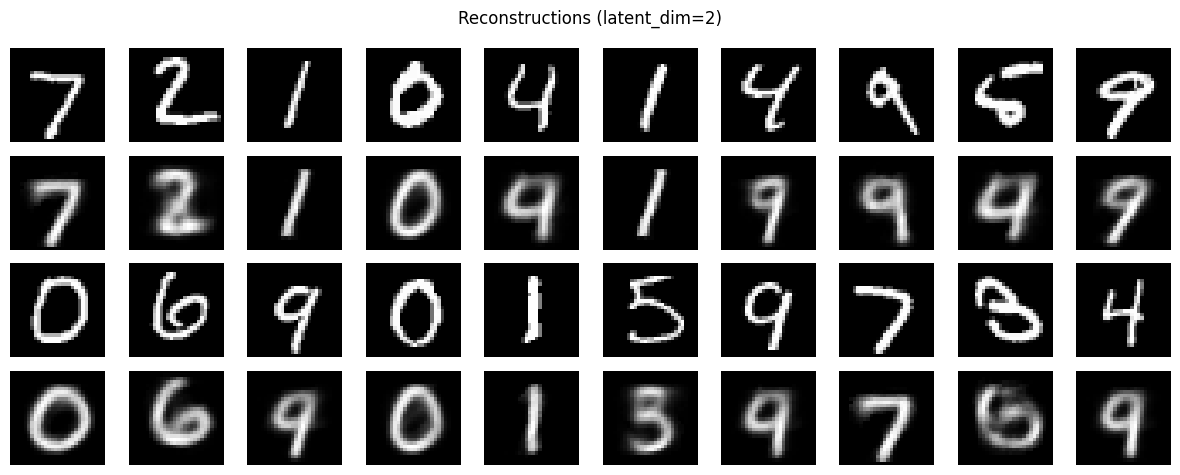


▶ Reconstructions latent_dim=8


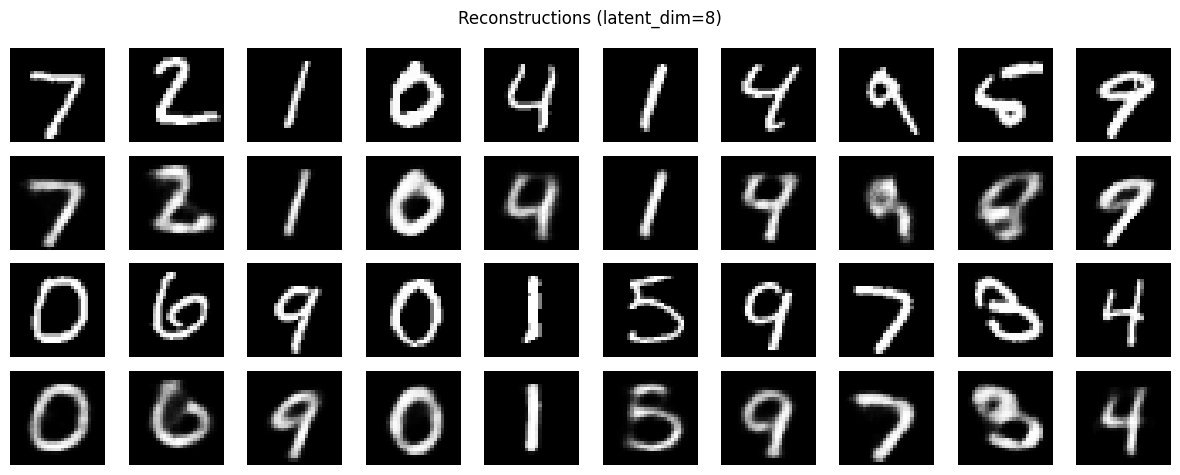


▶ Reconstructions latent_dim=32


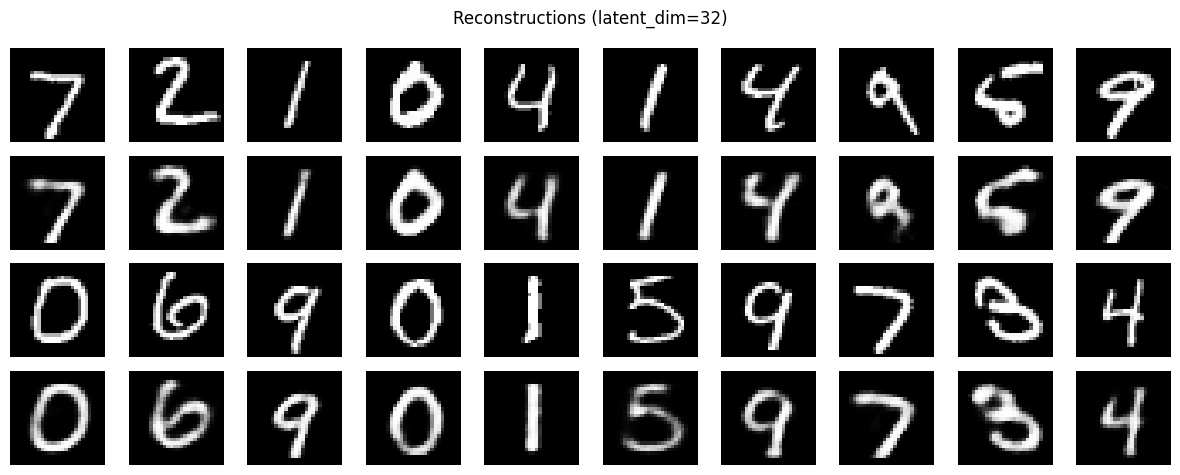


▶ Reconstructions latent_dim=64


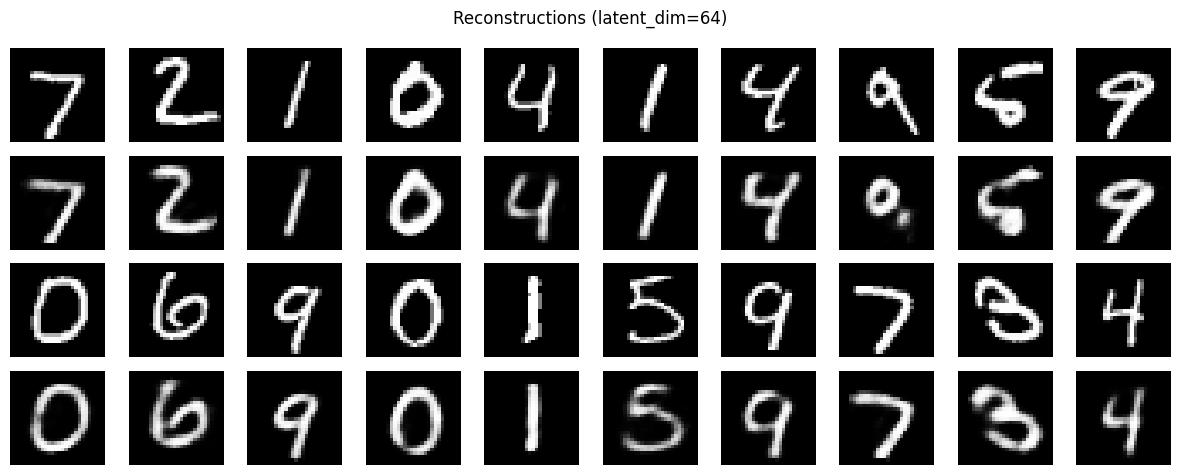

In [8]:
# Reconstruction Visualization
def visualize_reconstruction(model, loader, n=20, per_row=10):
    model.eval()
    imgs, _ = next(iter(loader))
    imgs = imgs[:n].view(-1, 784).to(device)
    with torch.no_grad():
        recons = model(imgs)
    origs  = imgs.cpu().view(-1, 28, 28).numpy()
    recons = recons.cpu().view(-1, 28, 28).numpy()

    rows = 2 * (n // per_row)
    fig, axes = plt.subplots(rows, per_row, figsize=(per_row*1.2, rows*1.2))
    for i in range(n):
        block = i // per_row
        col   = i % per_row
        axes[2*block,     col].imshow(origs[i],  cmap='gray'); axes[2*block,     col].axis('off')
        axes[2*block + 1, col].imshow(recons[i], cmap='gray'); axes[2*block + 1, col].axis('off')
    plt.suptitle(f'Reconstructions (latent_dim={model.encoder[-1].out_features})')
    plt.tight_layout()
    plt.show()

for dim in latent_dims:
    print(f'\n▶ Reconstructions latent_dim={dim}')
    visualize_reconstruction(results[dim], test_loader, n=20, per_row=10)


 Random samples latent_dim=8



 Random samples latent_dim=32


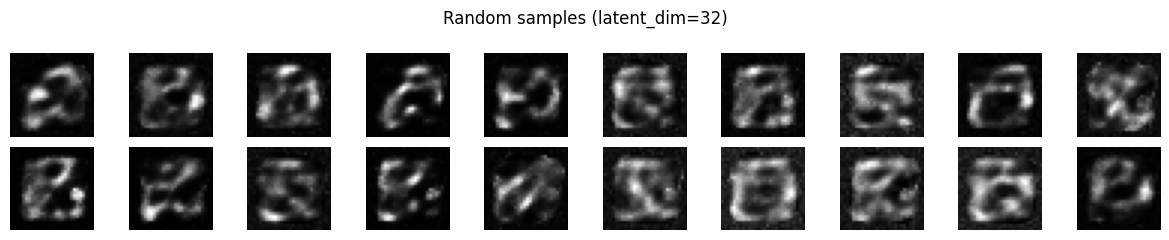

In [9]:
# 6. Sampling from Saved Checkpoints
def sample_and_plot_from_checkpoint(latent_dim, ckpt_path, n_samples=20, rows=2, cols=10):
    model = Autoencoder(latent_dim).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()
    z = torch.randn(n_samples, latent_dim, device=device)
    with torch.no_grad():
        decoded = model.decoder(z)
    imgs = decoded.cpu().view(-1, 28, 28).numpy()

    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.2, rows*1.2))
    for i in range(n_samples):
        r, c = divmod(i, cols)
        axes[r, c].imshow(imgs[i], cmap='gray')
        axes[r, c].axis('off')
    plt.suptitle(f'Random samples (latent_dim={latent_dim})')
    plt.tight_layout()
    plt.show()

for dim in [8, 32]:
    print(f'\n Random samples latent_dim={dim}')
    sample_and_plot_from_checkpoint(dim, f'ae_{dim}.pth')

In [10]:
# ---------------------------
# PART 1 : TASK 2
# ---------------------------

# --------------------------------------------
# Analysis of Variational Autoencoder (VAE)
# --------------------------------------------

latent_dim   = 2      # for visualization we use 2D latent

# -------- VAE MODEL ----------------------------
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # Encoder: 784 → 400 → (μ, logσ²)
        self.enc_fc1 = nn.Linear(784, 400)
        self.enc_mu  = nn.Linear(400, latent_dim)
        self.enc_logvar = nn.Linear(400, latent_dim)
        # Decoder: latent → 400 → 784
        self.dec_fc1 = nn.Linear(latent_dim, 400)
        self.dec_fc2 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.enc_fc1(x))
        return self.enc_mu(h1), self.enc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = torch.relu(self.dec_fc1(z))
        return torch.sigmoid(self.dec_fc2(h2))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [11]:
# ------------- LOSS FUNCTION -------------------------------------------
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    # KL divergence to N(0,1)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [12]:
# -------------------TRAIN VAE ---------------------------------------------
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(1, epochs+1):
    model.train()
    train_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.view(-1, 784).to(device)
        recon, mu, logvar = model(imgs)
        loss = vae_loss(recon, imgs, mu, logvar)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        train_loss += loss.item()
    print(f'Epoch {epoch}/{epochs} — Avg Loss: {train_loss/len(train_ds):.4f}')

Epoch 1/20 — Avg Loss: 204.6666
Epoch 2/20 — Avg Loss: 173.8227
Epoch 3/20 — Avg Loss: 167.2093
Epoch 4/20 — Avg Loss: 164.5558
Epoch 5/20 — Avg Loss: 162.9986
Epoch 6/20 — Avg Loss: 161.8071
Epoch 7/20 — Avg Loss: 160.7821
Epoch 8/20 — Avg Loss: 159.9260
Epoch 9/20 — Avg Loss: 159.0927
Epoch 10/20 — Avg Loss: 158.3294
Epoch 11/20 — Avg Loss: 157.6071
Epoch 12/20 — Avg Loss: 157.0346
Epoch 13/20 — Avg Loss: 156.4351
Epoch 14/20 — Avg Loss: 155.9539
Epoch 15/20 — Avg Loss: 155.5089
Epoch 16/20 — Avg Loss: 155.1354
Epoch 17/20 — Avg Loss: 154.7266
Epoch 18/20 — Avg Loss: 154.3303
Epoch 19/20 — Avg Loss: 154.0314
Epoch 20/20 — Avg Loss: 153.7271



 VAE random samples:


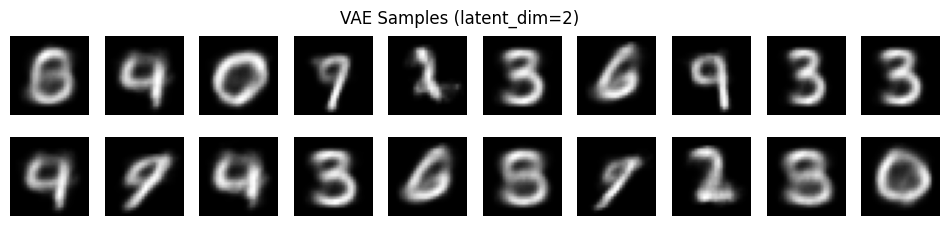

In [13]:
# --------------------- 6. SAMPLE FROM VAE ----------------------------------------
def sample_vae(decoder, n=20, rows=2, cols=10):
    z = torch.randn(n, latent_dim, device=device)
    with torch.no_grad():
        samples = decoder(z).cpu().view(-1, 28, 28).numpy()
    fig, ax = plt.subplots(rows, cols, figsize=(cols*1.2, rows*1.2))
    for i in range(n):
        r, c = divmod(i, cols)
        ax[r, c].imshow(samples[i], cmap='gray'); ax[r, c].axis('off')
    plt.suptitle(f'VAE Samples (latent_dim={latent_dim})'); plt.show()

print("\n VAE random samples:")
sample_vae(model.decode)

In [14]:
# ------------------- LATENT SPACE GRID VISUALIZATION ------------------------------------
def plot_latent_grid(decoder, grid_range, steps=20):
    xs = torch.linspace(grid_range[0], grid_range[1], steps)
    ys = torch.linspace(grid_range[0], grid_range[1], steps)
    grid = torch.stack(torch.meshgrid(xs, ys), -1).view(-1, 2).to(device)
    with torch.no_grad():
        imgs = decoder(grid).cpu().view(-1, 28, 28).numpy()
    fig, axes = plt.subplots(steps, steps, figsize=(steps, steps))
    idx = 0
    for i in range(steps):
        for j in range(steps):
            axes[i, j].imshow(imgs[idx], cmap='gray'); axes[i, j].axis('off')
            idx += 1
    plt.suptitle(f'Latent grid ∈ [{grid_range[0]},{grid_range[1]}]'); plt.show()

print("\n Latent grid in [−1,1]:")
plot_latent_grid(model.decode, [-1.0, 1.0], steps=15)

print("\n Latent grid in [−5,5]:")
plot_latent_grid(model.decode, [-5.0, 5.0], steps=15)


 Latent grid in [−1,1]:



 Latent grid in [−5,5]:


In [15]:

# ---------------------------
# PART 2 : TASK 1
# ---------------------------

# ------------------------------
# Deep Convolutional GAN
# ------------------------------

# ─── 1. Prepare Pokémon dataset (64×64 RGB) ───────────────────
d2l.DATA_HUB['pokemon'] = (
    d2l.DATA_URL + 'pokemon.zip',
    'c065c0e2593b8b161a2d7873e42418bf6a21106c'
)
data_dir = d2l.download_extract('pokemon')
transform = transforms.Compose([
    # Convert palette/transparent images to RGB
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
pokemon = datasets.ImageFolder(data_dir, transform=transform)
data_iter = DataLoader(
    pokemon, batch_size=128, shuffle=True,
    num_workers=d2l.get_dataloader_workers()
)

In [16]:
# ------------------ 2. Building blocks ---------------------------------
class G_block(nn.Module):
    def __init__(self, out_ch, in_ch, kernel=4, stride=2, pad=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, kernel, stride, pad, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(True)
        )
    def forward(self, X):
        return self.net(X)

class D_block(nn.Module):
    def __init__(self, out_ch, in_ch, kernel=4, stride=2, pad=1, alpha=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel, stride, pad, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(alpha, True)
        )
    def forward(self, X):
        return self.net(X)

In [17]:
# ─── 3. Generator & Discriminator ─────────────────────────────
n_G, n_D, latent_dim = 64, 64, 100

net_G = nn.Sequential(
    G_block(n_G*8, latent_dim, stride=1, pad=0),  # 512×4×4
    G_block(n_G*4, n_G*8),                        # 256×8×8
    G_block(n_G*2, n_G*4),                        # 128×16×16
    G_block(n_G,   n_G*2),                        #  64×32×32
    nn.ConvTranspose2d(n_G, 3, 4, 2, 1, bias=False),  # 3×64×64
    nn.Tanh()
)

net_D = nn.Sequential(
    D_block(n_D,    3),      #  64×32×32
    D_block(n_D*2,  n_D),    # 128×16×16
    D_block(n_D*4,  n_D*2),  # 256×8×8
    D_block(n_D*8,  n_D*4),  # 512×4×4
    nn.Conv2d(n_D*8, 1, 4, 1, 0)  # 1×1×1 logits
)

In [18]:
# ─── 4. Training function (D2L style) ────────────────────────
def train_dcgan(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
                device=d2l.try_gpu()):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    # Weight initialization
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    net_D, net_G = net_D.to(device), net_G.to(device)

    trainer_hp = {'lr': lr, 'betas': (0.5, 0.999)}
    trainer_D = optim.Adam(net_D.parameters(), **trainer_hp)
    trainer_G = optim.Adam(net_G.parameters(), **trainer_hp)

    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2,
                            figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)

    for epoch in range(1, num_epochs+1):
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            X, Z = X.to(device), Z.to(device)
            metric.add(
                d2l.update_D(X, Z, net_D, net_G, loss, trainer_D),
                d2l.update_G(Z, net_D, net_G, loss, trainer_G),
                batch_size
            )
        # show generated examples
        Z = torch.randn(21, latent_dim, 1, 1, device=device)
        fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5
        imgs = torch.cat([
            torch.cat([fake_x[i * 7 + j].cpu().detach()
                       for j in range(7)], dim=1)
            for i in range(len(fake_x)//7)
        ], dim=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # show losses
        loss_D, loss_G = metric[0]/metric[2], metric[1]/metric[2]
        animator.add(epoch, (loss_D, loss_G))

    print(f'Final losses — D: {loss_D:.3f}, G: {loss_G:.3f}')

In [19]:
# ─── 5. Run training with lr=2e-4 ──────────────────────────────
train_dcgan(net_D, net_G, data_iter, num_epochs=20,
            lr=2e-4, latent_dim=latent_dim)

Final losses — D: 0.121, G: 4.394


In [6]:
# ---------------------------
# PART 2 : TASK 2
# ---------------------------

# -------------------------------------------
# GAN Tuning and Evaluation with Leaky RELU and RELU
# --------------------------------------------
# ─── Data Loader ────────────────────────────────────────────
def get_loader(batch_size=128, image_size=64):
    url, zip_path, data_dir = (
        'https://d2l-data.s3.amazonaws.com/pokemon.zip',
        'pokemon.zip',
        'pokemon'
    )
    if not os.path.isdir(data_dir):
        urllib.request.urlretrieve(url, zip_path)
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall()
        os.remove(zip_path)
    transform = transforms.Compose([
        transforms.Lambda(lambda img: img.convert('RGB')), 
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    ds = datasets.ImageFolder(data_dir, transform=transform)
    return DataLoader(ds, batch_size, shuffle=True,
                      num_workers=min(4, os.cpu_count() or 1),
                      pin_memory=(device.type=='cuda'))

In [7]:
# ─── Discriminator block & factory ──────────────────────────
class D_block(nn.Module):
    def __init__(self, out_ch, in_ch, activation='leaky', alpha=0.2):
        super().__init__()
        act = nn.LeakyReLU(alpha, True) if activation=='leaky' else nn.ReLU(True)
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_ch),
            act
        )
    def forward(self, x): return self.net(x)

def build_discriminator(ndf=64, activation='leaky', alpha=0.2):
    layers = []
    for out, inp in [(ndf,3),(ndf*2,ndf),(ndf*4,ndf*2),(ndf*8,ndf*4)]:
        layers.append(D_block(out, inp, activation, alpha))
    layers.append(nn.Conv2d(ndf*8, 1, 4, 1, 0))  # logits
    return nn.Sequential(*layers)

In [8]:
# ─── Generator block & factory ─────────────────────────────
class G_block(nn.Module):
    def __init__(self, out_ch, in_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(True)
        )
    def forward(self, x): return self.net(x)

def build_generator(latent_dim=100, ngf=64):
    layers = [ nn.Sequential(
        nn.ConvTranspose2d(latent_dim, ngf*8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf*8), nn.ReLU(True)
    )]
    for out, inp in [(ngf*4,ngf*8),(ngf*2,ngf*4),(ngf,ngf*2)]:
        layers.append(G_block(out, inp))
    layers.append(nn.Sequential(
        nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False), nn.Tanh()
    ))
    return nn.Sequential(*layers)

In [9]:
# ─── Weight init ────────────────────────────────────────────
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.zeros_(m.bias)

In [10]:
# ─── 5. Experiment runner ──────────────────────────────────────
def run_experiment(activation, alpha, lr, epochs=20):
    print(f"\n>>> activation={activation}, α={alpha}, lr={lr}")
    loader = get_loader()
    netG = build_generator().to(device)
    netD = build_discriminator(activation=activation, alpha=alpha).to(device)
    netG.apply(init_weights); netD.apply(init_weights)

    criterion = nn.BCEWithLogitsLoss()
    optG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5,0.999))
    optD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5,0.999))
    fixed_noise = torch.randn(64, 100, 1, 1, device=device)

    D_losses, G_losses = [], []
    snapshots = {}

    for epoch in range(1, epochs+1):
        sumD = sumG = cnt = 0
        for X, _ in loader:
            b = X.size(0)
            X = X.to(device)
            real_lbl = torch.ones(b, device=device)
            fake_lbl = torch.zeros(b, device=device)

            # Discriminator step
            optD.zero_grad()
            Z = torch.randn(b, 100, 1, 1, device=device)
            out_real = netD(X).view(-1)
            out_fake = netD(netG(Z).detach()).view(-1)
            lossD = 0.5*(criterion(out_real, real_lbl) +
                         criterion(out_fake, fake_lbl))
            lossD.backward(); optD.step()

            # Generator step
            optG.zero_grad()
            Z2 = torch.randn(b, 100, 1, 1, device=device)
            out2 = netD(netG(Z2)).view(-1)
            lossG = criterion(out2, real_lbl)
            lossG.backward(); optG.step()

            sumD += lossD.item(); sumG += lossG.item(); cnt +=1

        D_losses.append(sumD/cnt); G_losses.append(sumG/cnt)

        # snapshot at epochs 1,5,10,15,20
        if epoch==1 or epoch%5==0:
            with torch.no_grad():
                imgs = netG(fixed_noise).cpu()
            snapshots[epoch] = utils.make_grid(imgs, nrow=8, normalize=True)

    # Plot losses
    plt.figure(figsize=(5,3))
    plt.plot(D_losses, label='D loss')
    plt.plot(G_losses, label='G loss')
    plt.title(f"{activation}, α={alpha}, lr={lr}")
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

    # Show snapshots
    for e, grid in snapshots.items():
        plt.figure(figsize=(3,3))
        plt.imshow(grid.permute(1,2,0)); plt.title(f"Epoch {e}"); plt.axis('off'); plt.show()


>>> activation=leaky, α=0.2, lr=0.0002


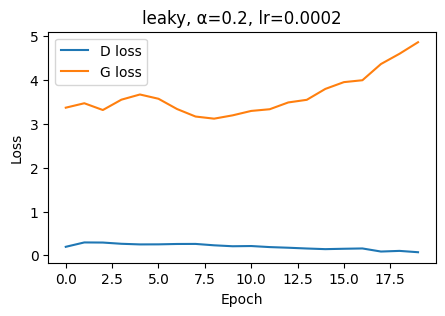

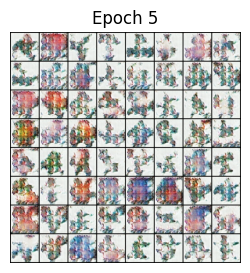

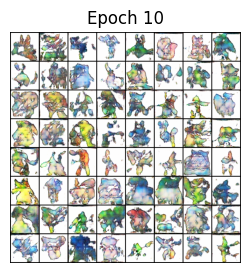

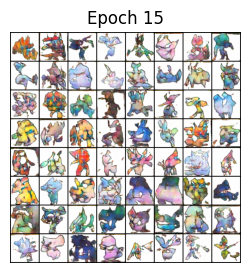

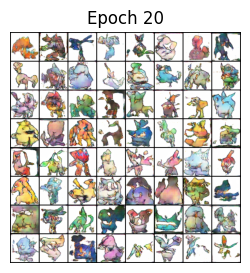


>>> activation=leaky, α=0.2, lr=0.0005


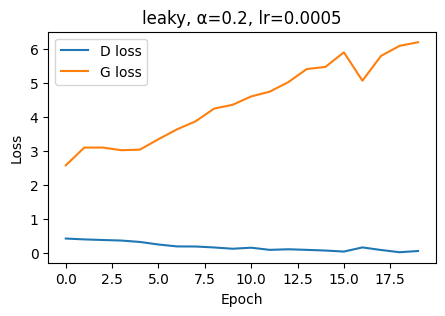

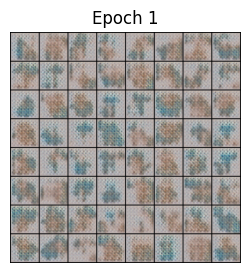

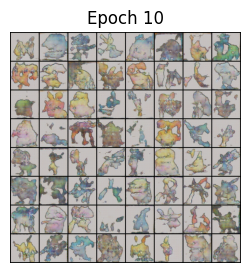

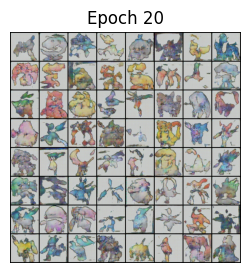


>>> activation=leaky, α=0.4, lr=0.0002


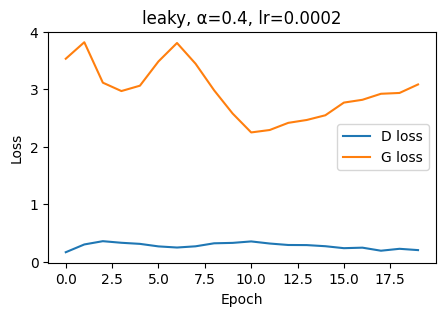

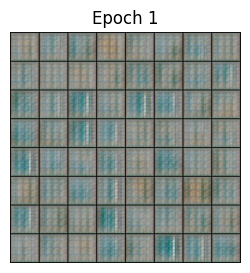

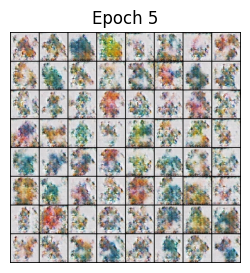

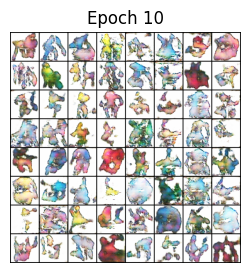

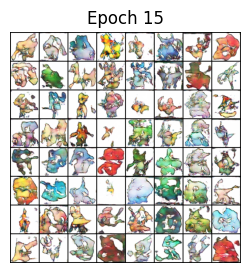


>>> activation=leaky, α=0.4, lr=0.0005


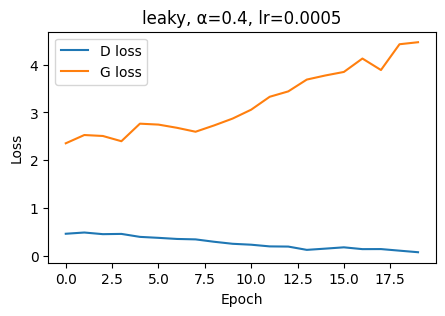

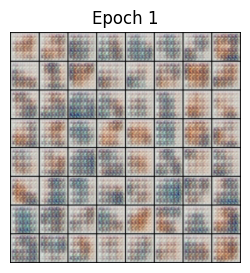

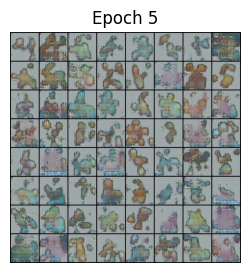

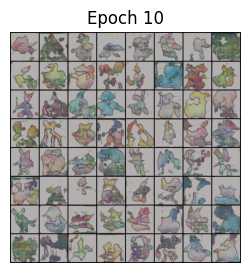

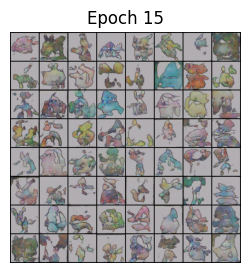


>>> activation=relu, α=0.2, lr=0.0002


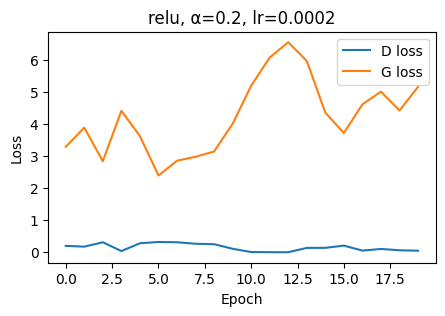

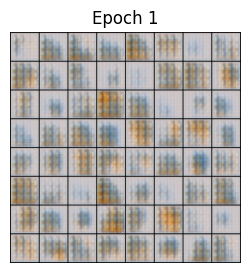

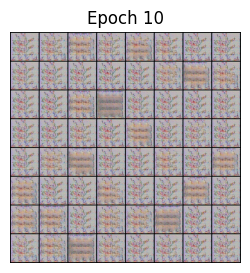


>>> activation=relu, α=0.2, lr=0.0005


In [ ]:
# ─── Run experiments ────────────────────────────────────────
for activation in ['leaky','relu']:
    alphas = [0.2] if activation=='relu' else [0.2,0.4]
    for alpha in alphas:
        for lr in [2e-4, 5e-4]:
            run_experiment(activation, alpha, lr, epochs=20)

In [ ]:
# -------------------------------------------------------------------------------------------------------------------------------
# GAN Tuning and Evaluation with only RELU: Didn't have time to run, but the project requirement is met in the above run itself
# -------------------------------------------------------------------------------------------------------------------------------

# 1. Data Loader
def get_loader(batch_size=128, image_size=64):
    url, zip_path, data_dir = (
        'https://d2l-data.s3.amazonaws.com/pokemon.zip',
        'pokemon.zip',
        'pokemon'
    )
    if not os.path.isdir(data_dir):
        urllib.request.urlretrieve(url, zip_path)
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall()
        os.remove(zip_path)
    transform = transforms.Compose([
        transforms.Lambda(lambda img: img.convert('RGB')),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    ds = datasets.ImageFolder(data_dir, transform=transform)
    return DataLoader(ds, batch_size, shuffle=True,
                      num_workers=min(4, os.cpu_count() or 1),
                      pin_memory=(device.type=='cuda'))

In [ ]:
# 2. Discriminator (ReLU only)
class D_block(nn.Module):
    def __init__(self, out_ch, in_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(True)
        )
    def forward(self, x):
        return self.net(x)

def build_discriminator(ndf=64):
    layers = []
    for out, inp in [(ndf,3), (ndf*2,ndf), (ndf*4,ndf*2), (ndf*8,ndf*4)]:
        layers.append(D_block(out, inp))
    layers.append(nn.Conv2d(ndf*8, 1, 4, 1, 0))  # logits
    return nn.Sequential(*layers)

In [ ]:
# 3. Generator
class G_block(nn.Module):
    def __init__(self, out_ch, in_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(True),
        )
    def forward(self, x):
        return self.net(x)

def build_generator(latent_dim=100, ngf=64):
    layers = [
        nn.Sequential(
            nn.ConvTranspose2d(latent_dim, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
        )
    ]
    for out, inp in [(ngf*4,ngf*8), (ngf*2,ngf*4), (ngf,ngf*2)]:
        layers.append(G_block(out, inp))
    layers.append(nn.Sequential(
        nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
        nn.Tanh(),
    ))
    return nn.Sequential(*layers)

In [ ]:
# Weight init
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.zeros_(m.bias)

In [ ]:
# 5. Experiment runner
def run_relu_experiment(lr, betas, epochs=20):
    print(f"\n>>> ReLU Discriminator | lr={lr}, betas={betas}, epochs={epochs}")
    loader = get_loader()
    netG = build_generator().to(device)
    netD = build_discriminator().to(device)
    netG.apply(init_weights)
    netD.apply(init_weights)

    criterion = nn.BCEWithLogitsLoss()
    optG = optim.Adam(netG.parameters(), lr=lr, betas=betas)
    optD = optim.Adam(netD.parameters(), lr=lr, betas=betas)
    fixed_noise = torch.randn(64, 100, 1, 1, device=device)

    D_losses, G_losses = [], []
    snapshots = {}

    for epoch in range(1, epochs+1):
        sumD = sumG = cnt = 0
        for X, _ in loader:
            b = X.size(0)
            X = X.to(device)
            real_lbl = torch.ones(b, device=device)
            fake_lbl = torch.zeros(b, device=device)

            # Discriminator update
            optD.zero_grad()
            Z = torch.randn(b, 100, 1, 1, device=device)
            out_real = netD(X).view(-1)
            out_fake = netD(netG(Z).detach()).view(-1)
            lossD = 0.5 * (criterion(out_real, real_lbl) + criterion(out_fake, fake_lbl))
            lossD.backward()
            optD.step()

            # Generator update
            optG.zero_grad()
            Z2 = torch.randn(b, 100, 1, 1, device=device)
            out2 = netD(netG(Z2)).view(-1)
            lossG = criterion(out2, real_lbl)
            lossG.backward()
            optG.step()

            sumD += lossD.item()
            sumG += lossG.item()
            cnt  += 1

        D_losses.append(sumD/cnt)
        G_losses.append(sumG/cnt)

        # Snapshot at epochs 1, 10, and epochs
        if epoch in (1, 10, epochs):
            with torch.no_grad():
                imgs = netG(fixed_noise).cpu()
            snapshots[epoch] = utils.make_grid(imgs, nrow=8, normalize=True)

    # Plot losses
    plt.figure(figsize=(5,3))
    plt.plot(D_losses, label='D loss')
    plt.plot(G_losses, label='G loss')
    plt.title(f"ReLU Discriminator | lr={lr}, betas={betas}")
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    plt.show()

    # Display snapshots
    for e, grid in snapshots.items():
        plt.figure(figsize=(3,3))
        plt.imshow(grid.permute(1,2,0))
        plt.title(f"Epoch {e}")
        plt.axis('off')
        plt.show()

In [ ]:
# 6. Run two experiments, betas are the decay rates:
# a) lr=0.0005, beta1=0.5
run_relu_experiment(lr=5e-4, betas=(0.5, 0.999), epochs=20)
# b) lr=2e-4, beta1=0.9
run_relu_experiment(lr=2e-4, betas=(0.9, 0.999), epochs=20)